In [1]:
import os
import csv

import torch
import torchvision
from PIL import Image

from segwork.data.dataset import SegmentationDataset
from segwork.data.transforms import PILToTensor

In [87]:
class DroneDataset(SegmentationDataset):

    NUM_CLASSES = 20

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        _TRAINING_DIR = os.path.join(self.root,'training_set')
        self.TRAINING_IMAGES_DIR = os.path.join(_TRAINING_DIR, 'images')
        self.TRAINING_SEMANTICS = os.path.join(_TRAINING_DIR, 'gt', 'semantic')
        self.TRAINING_LABELS_DIR = os.path.join(self.TRAINING_SEMANTICS, 'label_images')

    def __getitem__(self, idx:int):
        assert len(self.images) == len(self.annotations), \
            f'Different number of images and labels. Images: {len(self.images)} Labels:{self.labels}'
        
        image = self.load_image(idx)
        label = self.load_label(idx)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)
                
        return (image, label)
        
    def __len__(self):
        assert len(self.images) == len(self.annotations), \
            f'Different number of images and labels. Images: {len(self.images)} Labels:{self.labels}'
        return len(self.images)

    @property
    def images(self):
        return [os.path.join(self.TRAINING_IMAGES_DIR, file) for file in os.listdir(self.TRAINING_IMAGES_DIR)]

    def load_image(self, idx:int, mode = torchvision.io.ImageReadMode.UNCHANGED):
        """Returns the image specified with the index"""
        # return torchvision.io.read_image(self.images[idx], mode)
        return Image.open(self.images[idx])

    @property
    def annotations(self):
        return [os.path.join(self.TRAINING_LABELS_DIR, file) for file in os.listdir(self.TRAINING_LABELS_DIR)]

    def load_label(self, idx:int, mode = torchvision.io.ImageReadMode.GRAY):
        """Returns the label specified with the index"""
        # return torchvision.io.read_image(self.annotations[idx], mode)
        return Image.open(self.annotations[idx])

    @property
    def mask_colors(self):
        """Returns a dict with the class labels and class colors"""
        with open(os.path.join(self.TRAINING_SEMANTICS, 'class_dict.csv' )) as csvfile:
            reader = csv.reader(csvfile)
            return { tuple([int(r.strip()),int(g.strip()),int(b.strip())]) : name for (name, r, g, b) in reader  }

    @property
    def mask_colors_index(self):
        return { key : idx for idx, key in enumerate(self.mask_colors)}


In [88]:
# dataset = DroneDataset( root= os.path.join(os.getcwd(), 'data', 'semantic_drone_dataset,'))
dataset = DroneDataset( 
    root = os.path.join(os.getcwd(), 'data', 'semantic_drone_dataset'), 
    transform=torchvision.transforms.ToTensor(),
    target_transform = torchvision.transforms.PILToTensor())
    

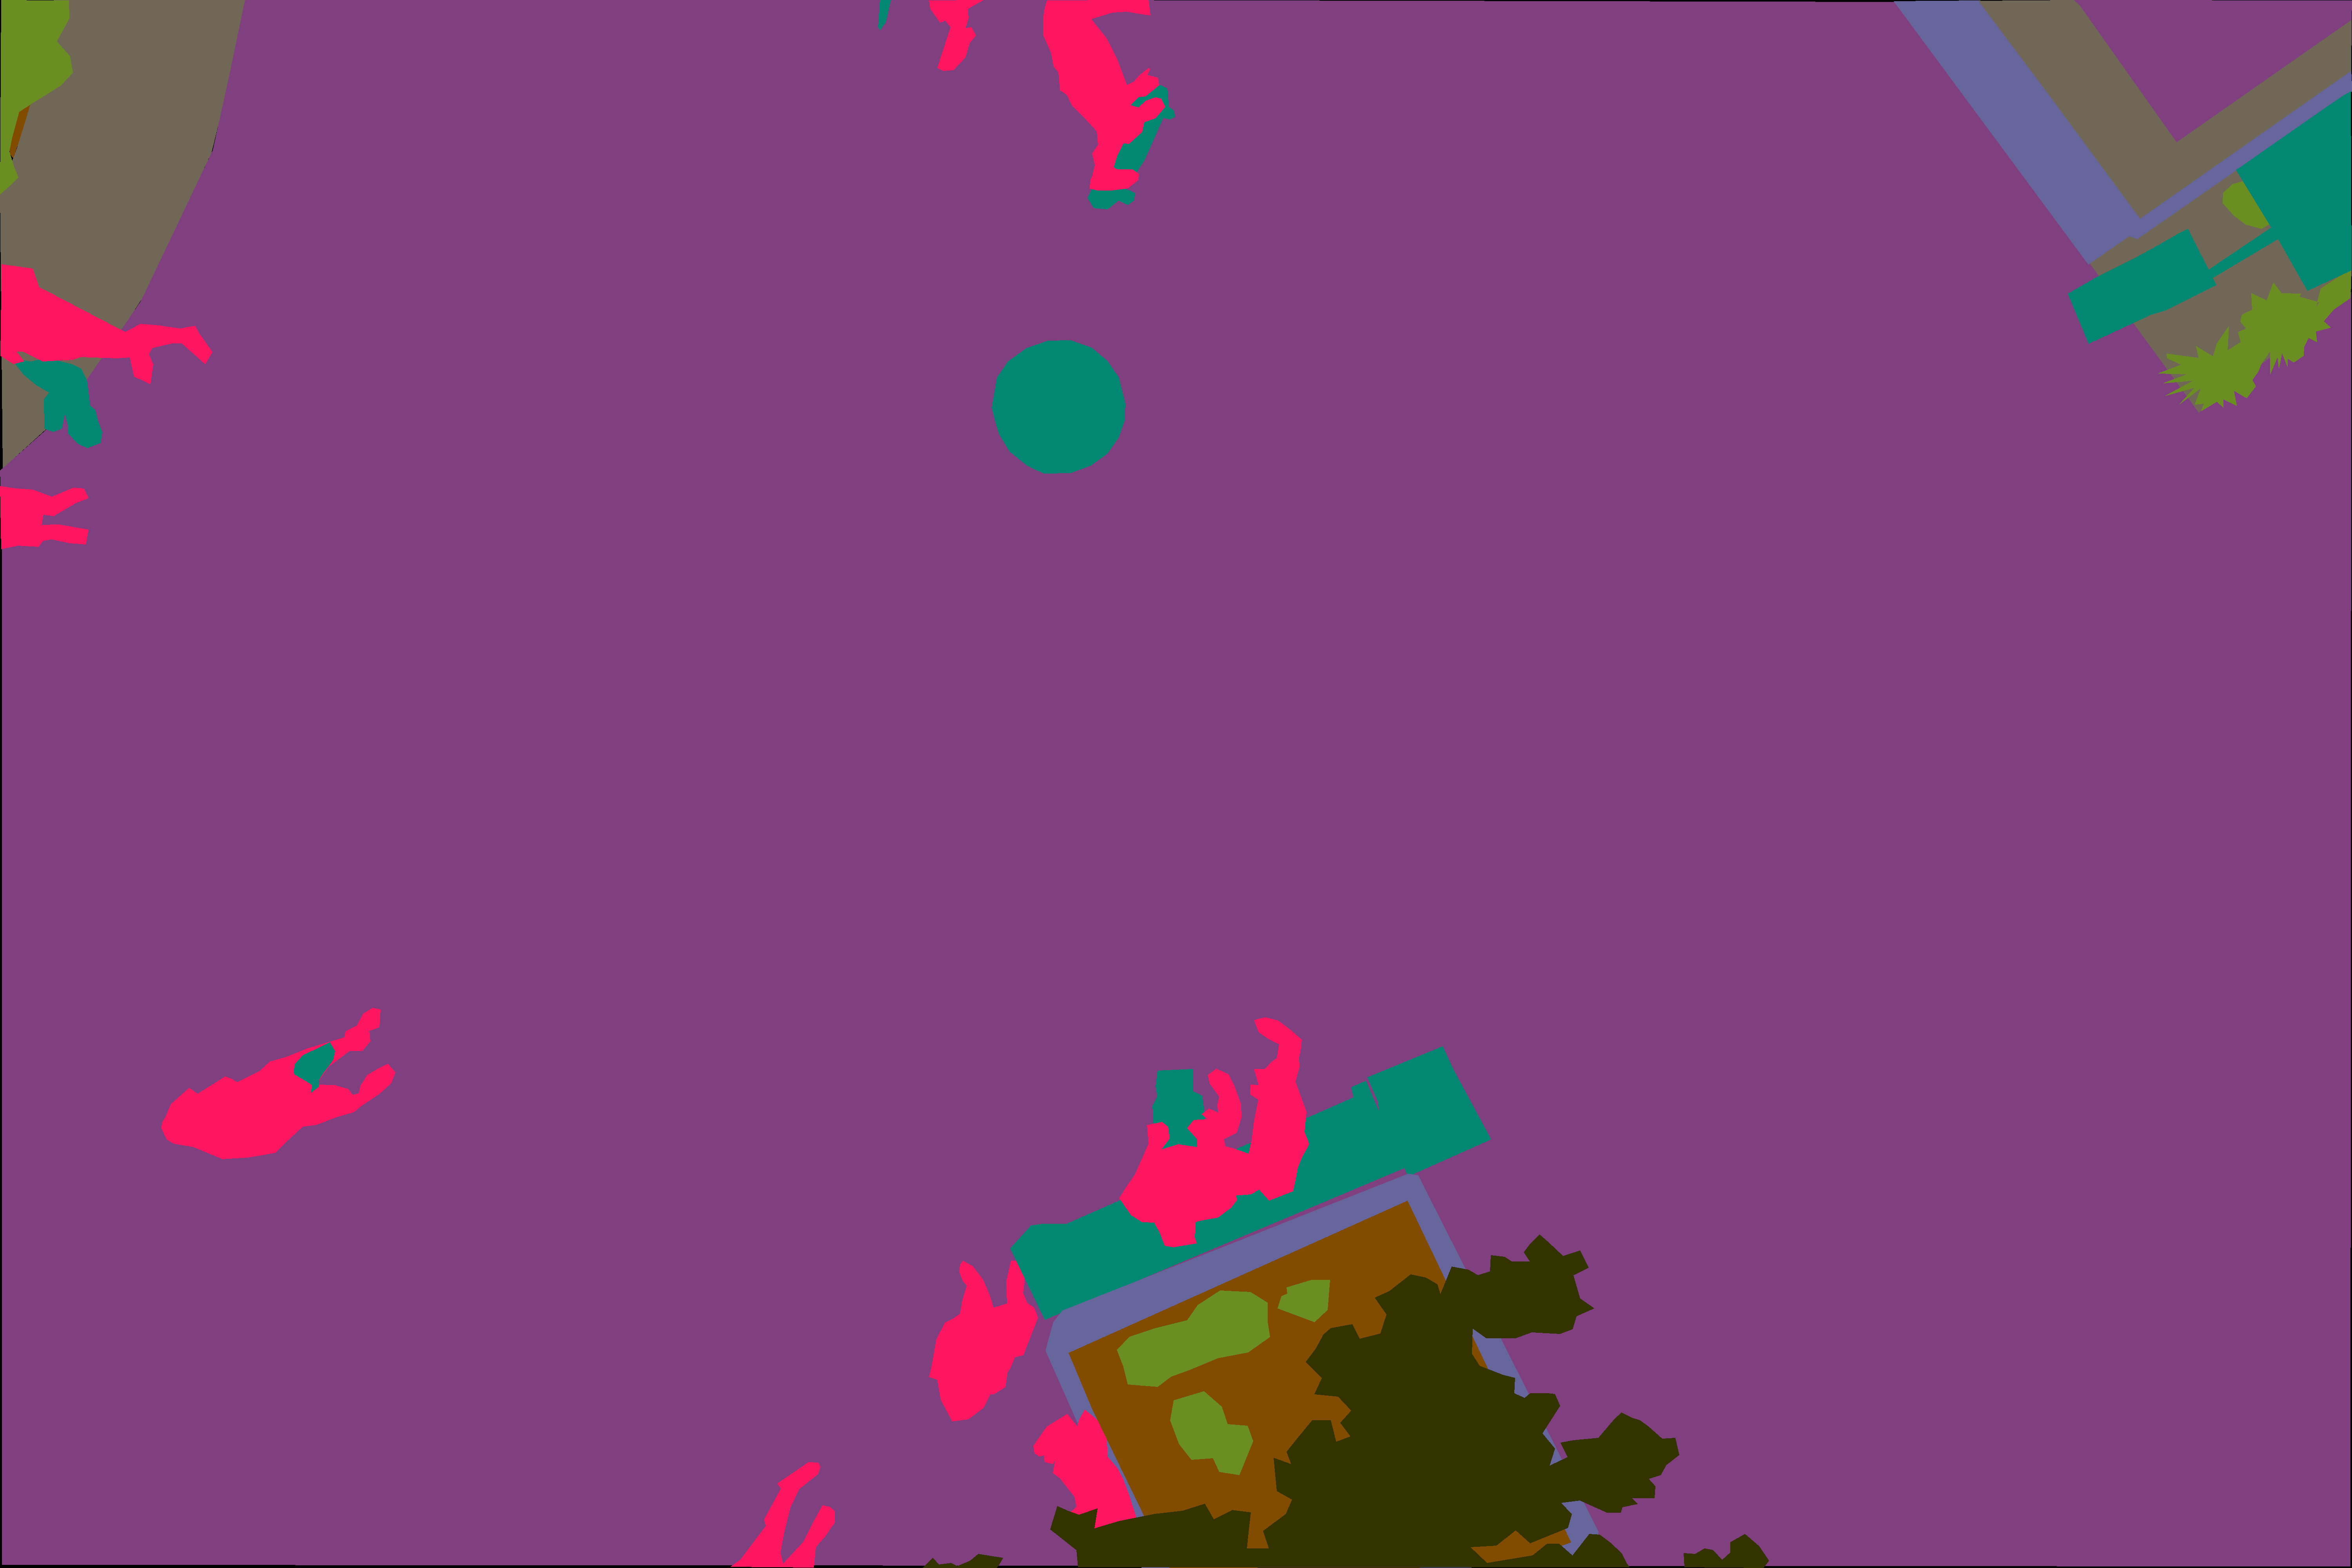

In [89]:
import torchvision.transforms as T
transform = T.ToPILImage()
image, label = dataset[0]
mask_png = transform(label)
mask_png

In [117]:
import numpy as np

_, label = dataset[0]
h, w = label.size()[-2:]
mask = torch.zeros(h, w).long()

for color in dataset.mask_colors_index:
    idx = (label == torch.tensor(color, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
    validx = (idx.sum(0) == 3)          
    mask[validx] = torch.tensor(dataset.mask_colors_index[color], dtype=torch.long)

file_name = f'{0:03d}.npy'
dir_name = os.path.join(dataset.TRAINING_SEMANTICS, 'label_numpy')
path_name = os.path.join(dir_name, file_name)

with open(path_name, 'wb') as file:
    np.save(file, mask.numpy())      


In [118]:
file_name = f'{0:03d}.npy'
dir_name = os.path.join(dataset.TRAINING_SEMANTICS, 'label_numpy')
path_name = os.path.join(dir_name, file_name)

with open(path_name, 'rb') as file:
    np_mask = np.load(file)

np_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [109]:
file_name = f'{0:03d}'
dir_name = os.path.join(dataset.TRAINING_SEMANTICS, 'label_numpy')
path_name = os.path.join(dir_name, file_name)
path_name

'c:\\Users\\alvar\\Projects\\segwork\\data\\semantic_drone_dataset\\training_set\\gt\\semantic\\label_numpy\\000'

In [80]:
mask.size()

torch.Size([1, 4000, 6000])

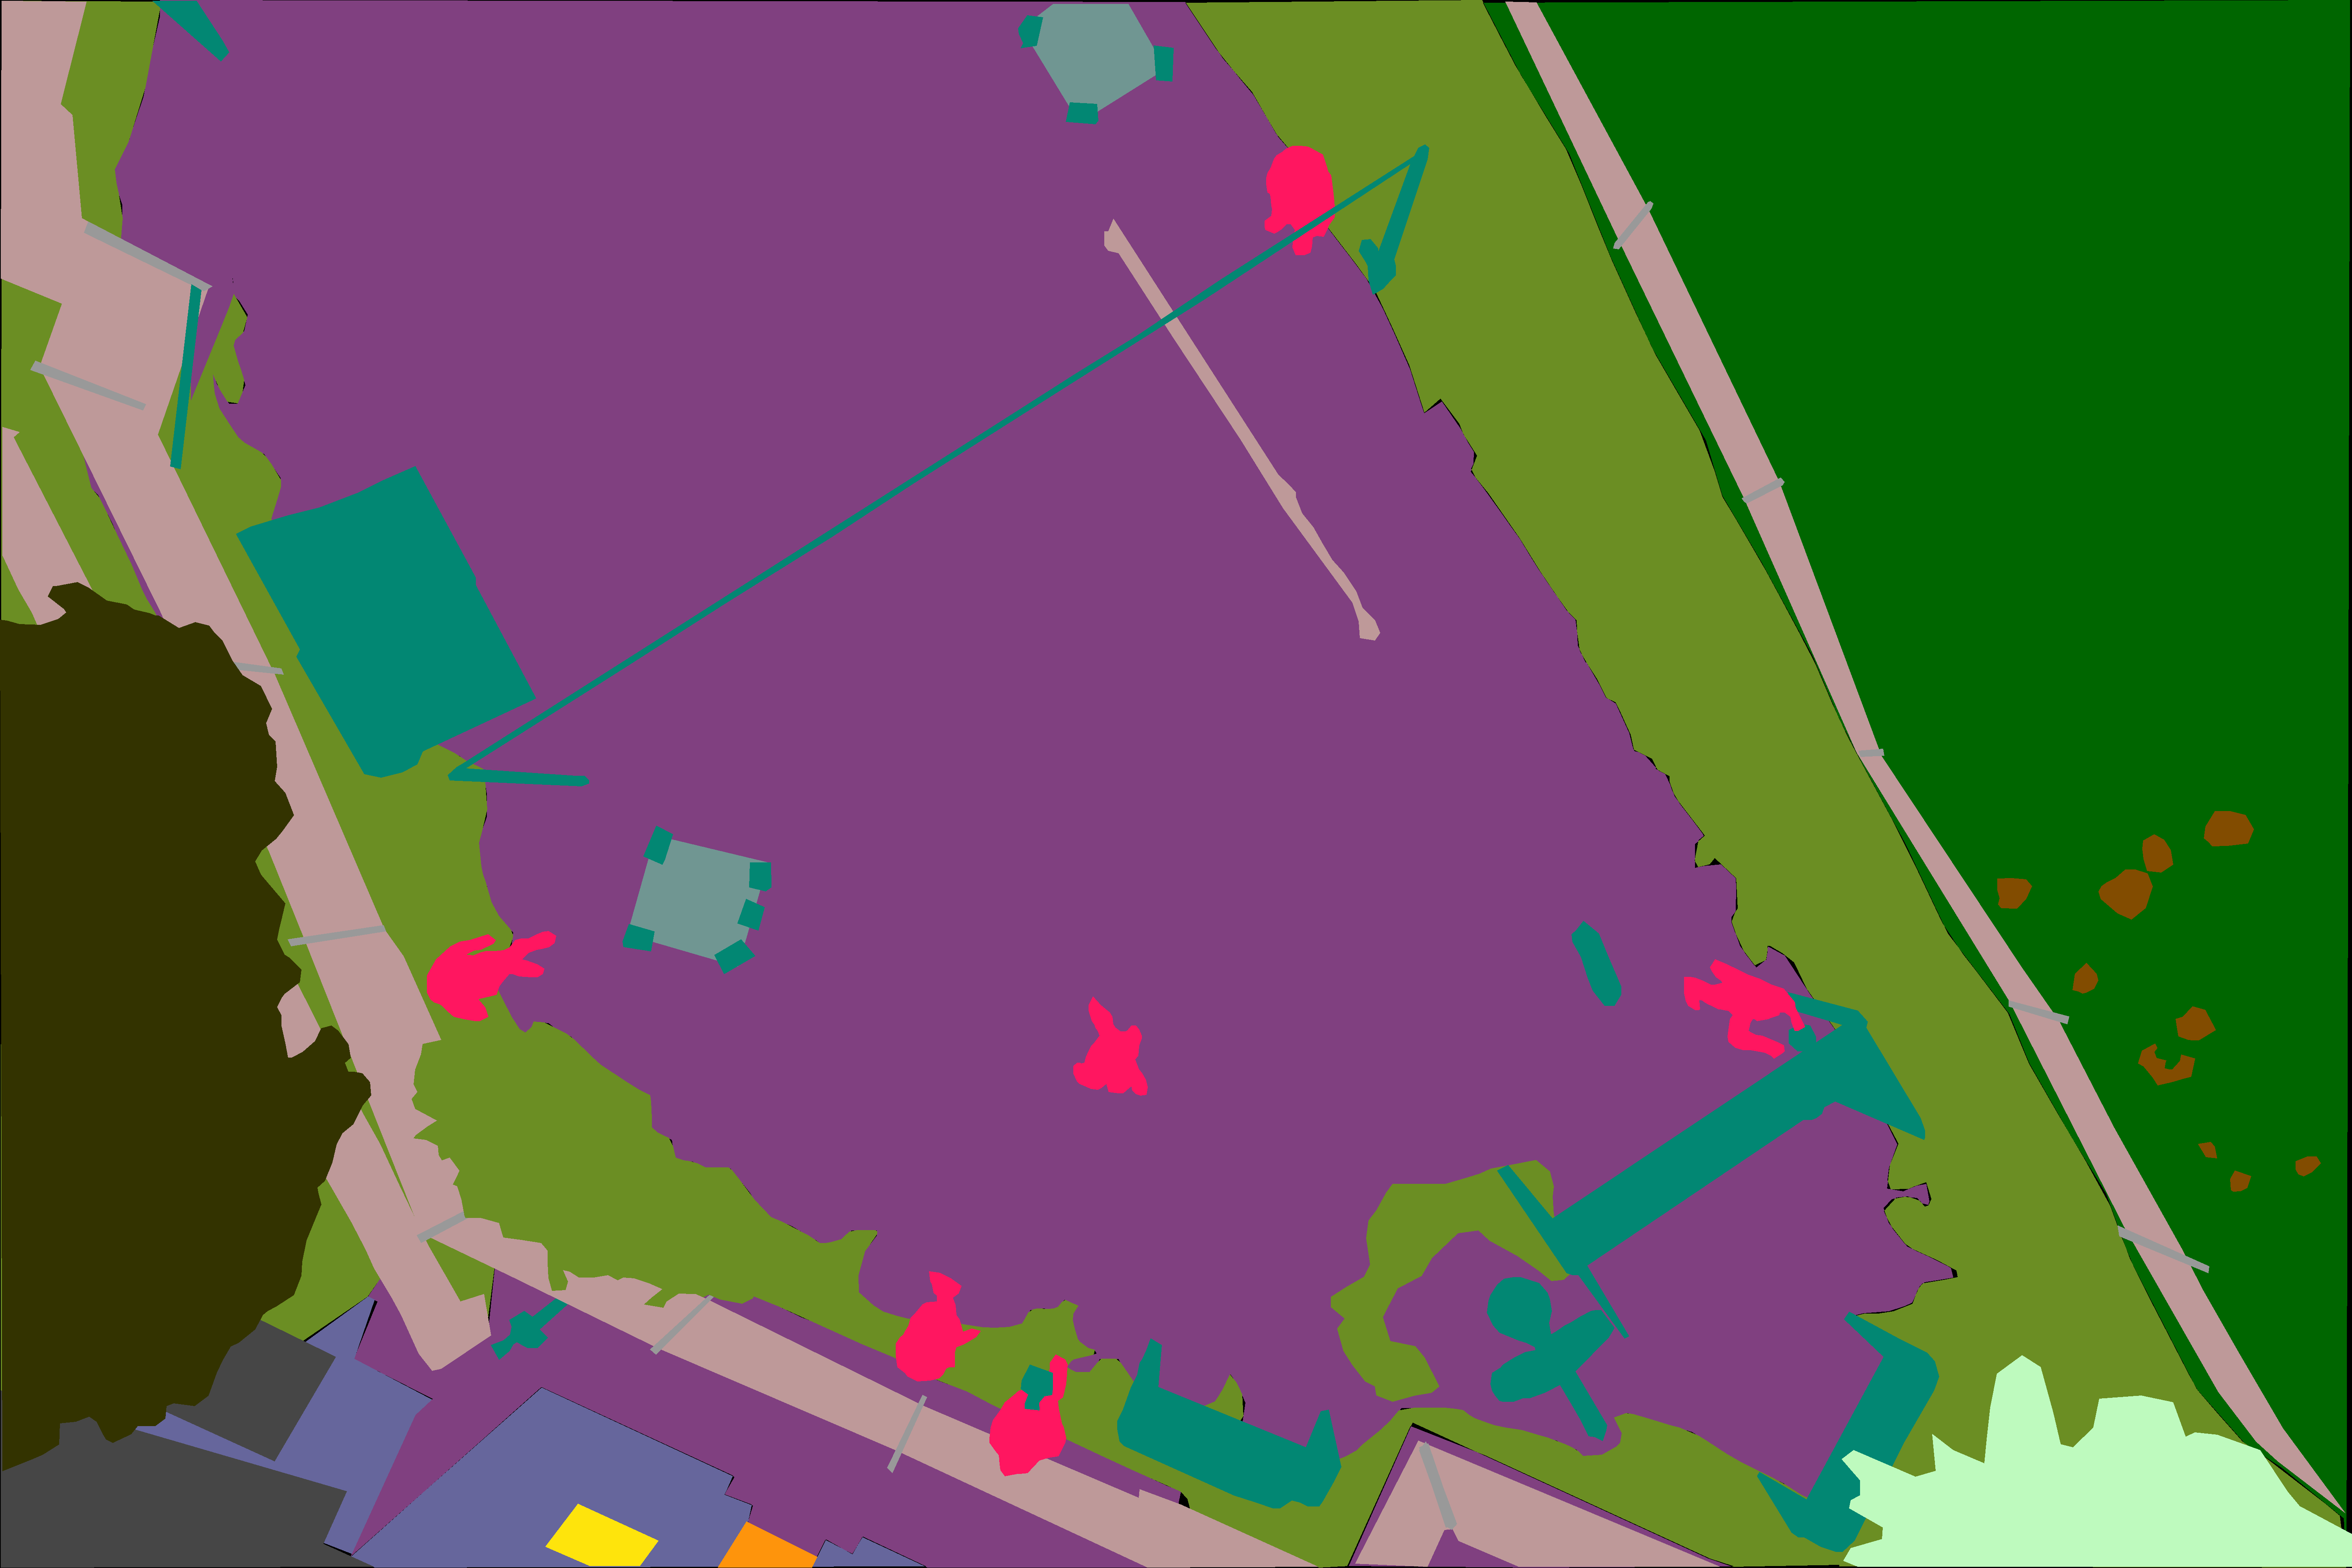

In [11]:
label = dataset.load_label(1)
label



In [10]:
# Generate mask annotations from PNG
dataset.annotations[0]

'c:\\Users\\alvar\\Projects\\segwork\\data\\semantic_drone_dataset\\training_set\\gt\\semantic\\label_images\\000.png'

## Visualizer

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



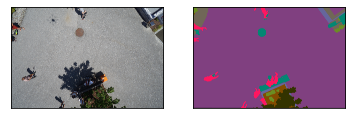

In [13]:
image, target = dataset[0]
show([image, target])

### Generate masks

In [75]:
# print(label.size())
# len(dataset.mask_colors)
dataset.mask_colors

{(0, 0, 0): 'unlabeled',
 (128, 64, 128): 'paved-area',
 (130, 76, 0): 'dirt',
 (0, 102, 0): 'grass',
 (112, 103, 87): 'gravel',
 (28, 42, 168): 'water',
 (48, 41, 30): 'rocks',
 (0, 50, 89): 'pool',
 (107, 142, 35): 'vegetation',
 (70, 70, 70): 'roof',
 (102, 102, 156): 'wall',
 (254, 228, 12): 'window',
 (254, 148, 12): 'door',
 (190, 153, 153): 'fence',
 (153, 153, 153): 'fence-pole',
 (255, 22, 96): 'person',
 (102, 51, 0): 'dog',
 (9, 143, 150): 'car',
 (119, 11, 32): 'bicycle',
 (51, 51, 0): 'tree',
 (190, 250, 190): 'bald-tree',
 (112, 150, 146): 'ar-marker',
 (2, 135, 115): 'obstacle',
 (255, 0, 0): 'conflicting'}

In [66]:
reshaped_lb = label.reshape(3, label.size()[-1] * label.size()[-2])
reshaped_lb.size()
reshaped_lb[:,:20]

tensor([[  0,   0,   0, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107,
         107, 107, 107, 107, 107, 107],
        [  0,   0,   0, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
         142, 142, 142, 142, 142, 142],
        [  0,   0,   0,  35,  35,  35,  35,  35,  35,  35,  35,  35,  35,  35,
          35,  35,  35,  35,  35,  35]], dtype=torch.uint8)

## Calculate weights

array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ..., 90, 90, 90],
        [ 0,  0,  0, ..., 90, 90, 90],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]]], dtype=uint8)

In [28]:
counts_out = np.unique(target_np, return_counts=True)
counts = zip(counts_out[0], counts_out[1])
dic_count = dict(counts)
dic_count

{0: 60393,
 45: 589714,
 83: 293514,
 90: 20883680,
 92: 516134,
 100: 524123,
 103: 633602,
 108: 287613,
 119: 211227}

[]